In [1]:
from pathlib import Path

import numpy as np

# import pysr before torch to avoid
# UserWarning: torch was imported before juliacall. This may cause a segfault. To avoid this, import juliacall before importing torch. For updates, see https://github.com/pytorch/pytorch/issues/78829.
import pysr  # noqa: F401
from zanj import ZANJ

from maze_dataset import LatticeMazeGenerators, MazeDataset, MazeDatasetConfig
from maze_dataset.benchmark.config_sweep import (
	SweepResult,
	dataset_success_fraction,
	full_percolation_analysis,
	plot_grouped,
)
from maze_dataset.benchmark.sweep_fit import sweep_fit

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


# run a basic analysis

tqdm_allowed_kwargs = {'ncols', 'desc', 'lock_args', 'miniters', 'total', 'unit_scale', 'bar_format', 'delay', 'postfix', 'position', 'gui', 'dynamic_ncols', 'smoothing', 'file', 'self', 'initial', 'unit_divisor', 'colour', 'leave', 'write_bytes', 'maxinterval', 'disable', 'unit', 'iterable', 'mininterval', 'ascii', 'nrows'}
mapped_kwargs = {'total': 3, 'desc': 'Processing 3 items'}


Processing 3 items: 100%|██████████| 3/3 [00:01<00:00,  2.76it/s]


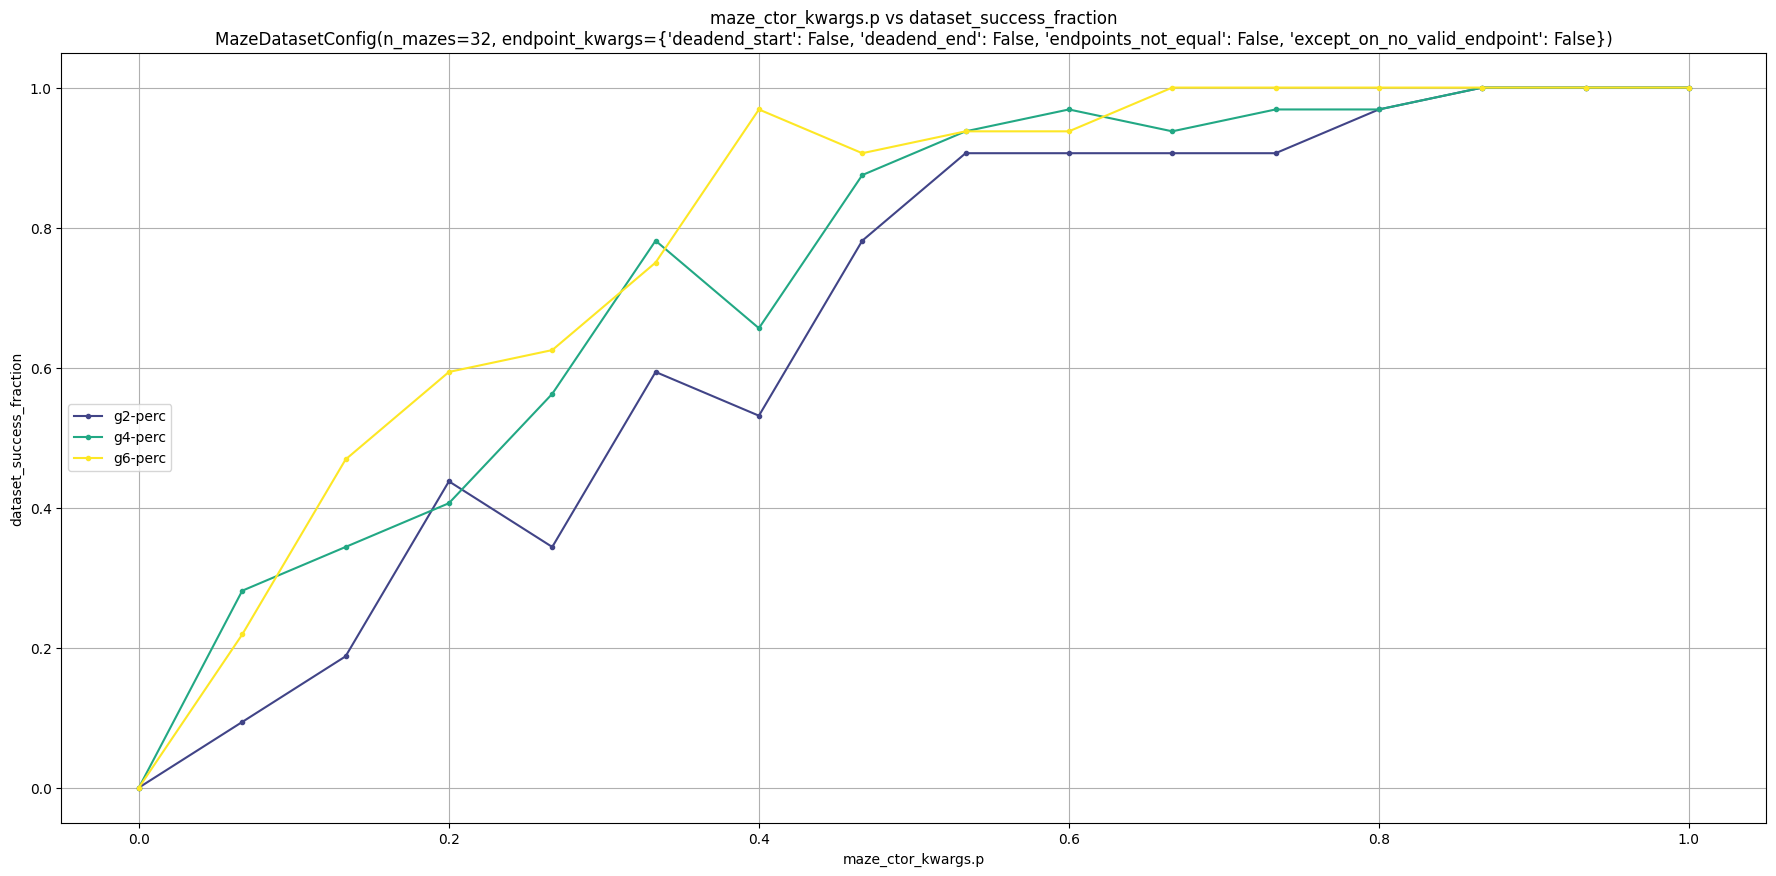

<Axes: title={'center': "maze_ctor_kwargs.p vs dataset_success_fraction\nMazeDatasetConfig(n_mazes=32, endpoint_kwargs={'deadend_start': False, 'deadend_end': False, 'endpoints_not_equal': False, 'except_on_no_valid_endpoint': False})"}, xlabel='maze_ctor_kwargs.p', ylabel='dataset_success_fraction'>

In [2]:
# Run the analysis
results: SweepResult = SweepResult.analyze(
	configs=[
		MazeDatasetConfig(
			name=f"g{grid_n}-perc",
			grid_n=grid_n,
			n_mazes=32,
			maze_ctor=LatticeMazeGenerators.gen_percolation,
			maze_ctor_kwargs=dict(),
			endpoint_kwargs=dict(
				deadend_start=False,
				deadend_end=False,
				endpoints_not_equal=False,
				except_on_no_valid_endpoint=False,
			),
		)
		for grid_n in [2, 4, 6]
	],
	param_values=np.linspace(0.0, 1.0, 16).tolist(),
	param_key="maze_ctor_kwargs.p",
	analyze_func=dataset_success_fraction,
	parallel=False,
)

# Plot results
results.plot(save_path=None, cfg_keys=["n_mazes", "endpoint_kwargs"])


## check saving/loading

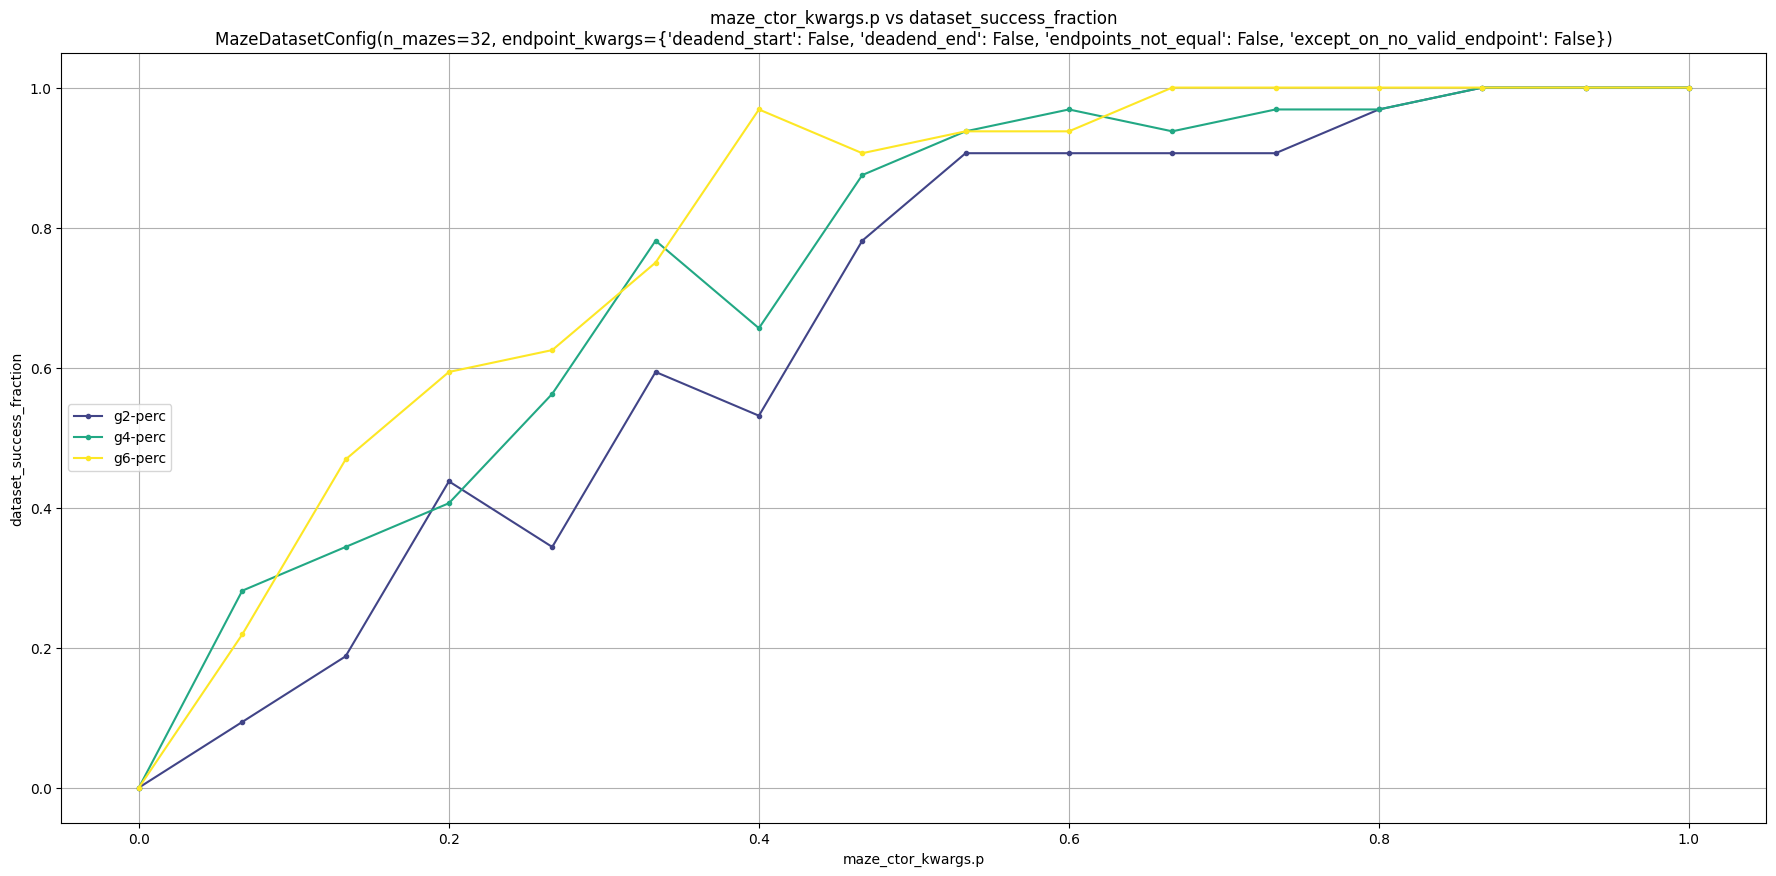

<Axes: title={'center': "maze_ctor_kwargs.p vs dataset_success_fraction\nMazeDatasetConfig(n_mazes=32, endpoint_kwargs={'deadend_start': False, 'deadend_end': False, 'endpoints_not_equal': False, 'except_on_no_valid_endpoint': False})"}, xlabel='maze_ctor_kwargs.p', ylabel='dataset_success_fraction'>

In [3]:
path = Path("../tests/_temp/dataset_frac_sweep/results_small.zanj")
results.save(path)
ZANJ().read(path).plot(cfg_keys=["n_mazes", "endpoint_kwargs"])

# sweep acrossall endpoint kwargs and generator funcs 

In [4]:
results_sweep: SweepResult = full_percolation_analysis(
	n_mazes=16,
	p_val_count=11,
	grid_sizes=[2, 4, 6],
	parallel=False,
	save_dir=Path("tests/_temp/dataset_frac_sweep"),
)

tqdm_allowed_kwargs = {'ncols', 'desc', 'lock_args', 'miniters', 'total', 'unit_scale', 'bar_format', 'delay', 'postfix', 'position', 'gui', 'dynamic_ncols', 'smoothing', 'file', 'self', 'initial', 'unit_divisor', 'colour', 'leave', 'write_bytes', 'maxinterval', 'disable', 'unit', 'iterable', 'mininterval', 'ascii', 'nrows'}
mapped_kwargs = {'total': 18, 'desc': 'Processing 18 items'}


Processing 18 items: 100%|██████████| 18/18 [00:05<00:00,  3.37it/s]


Saving results to tests/_temp/dataset_frac_sweep/result-n16-c18-p11.zanj


In [5]:
results_medium: SweepResult = SweepResult.read(
	"../docs/benchmarks/percolation_fractions/medium/result-n128-c42-p50.zanj",
	# "../docs/benchmarks/percolation_fractions/large/result-n256-c54-p100.zanj"
)

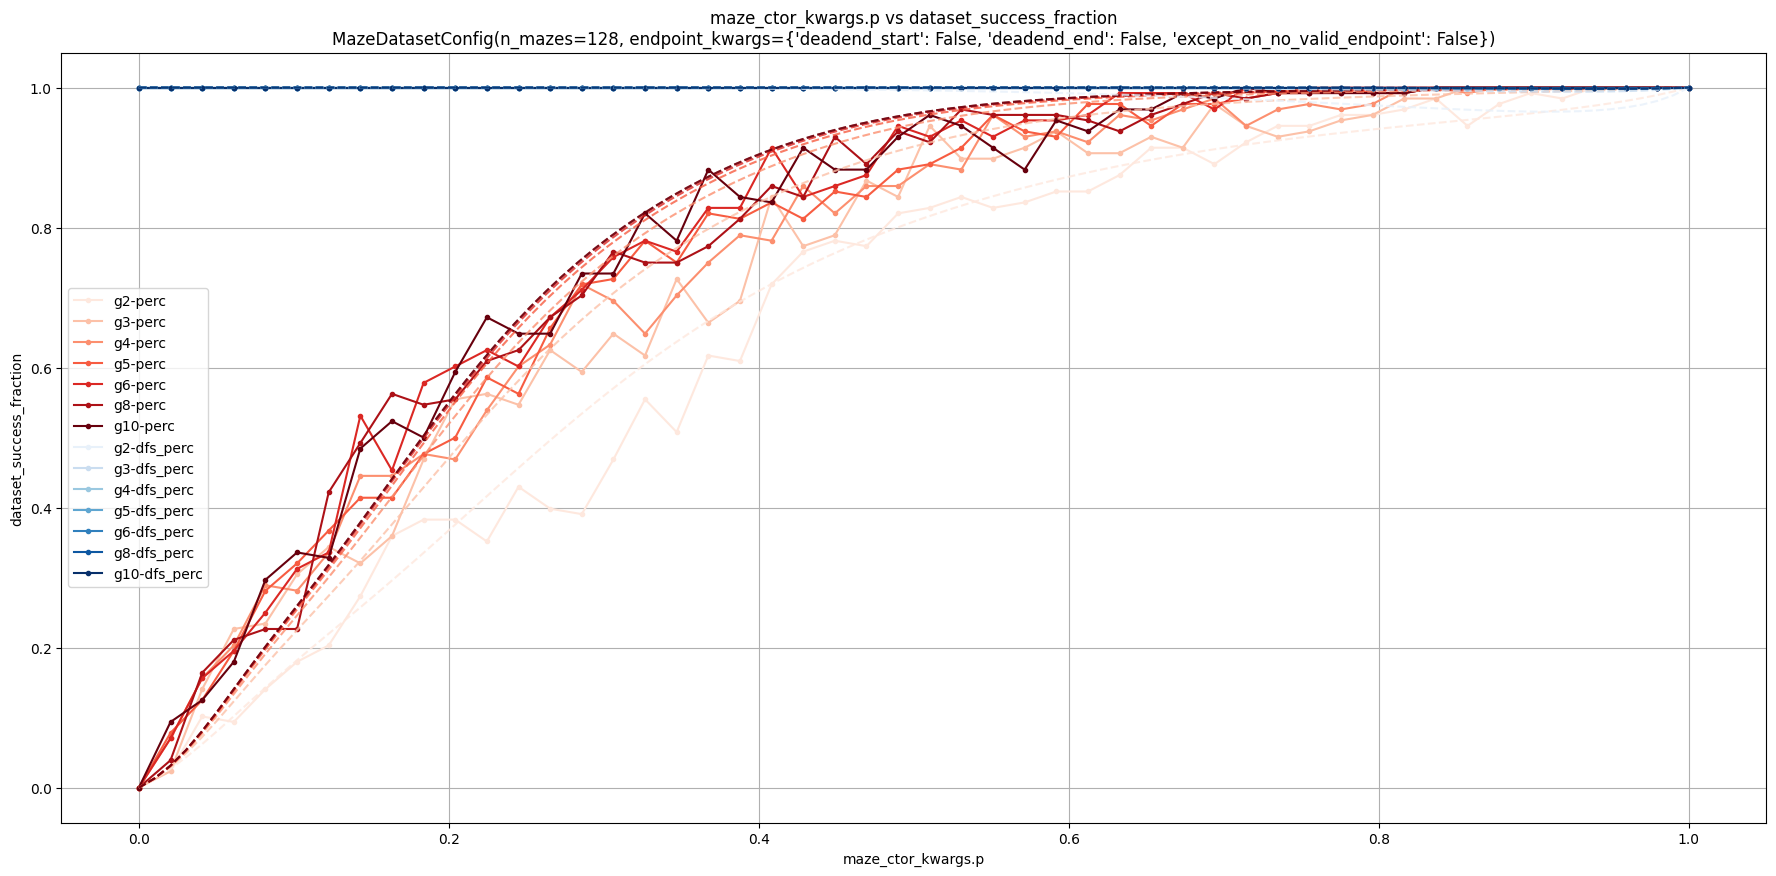

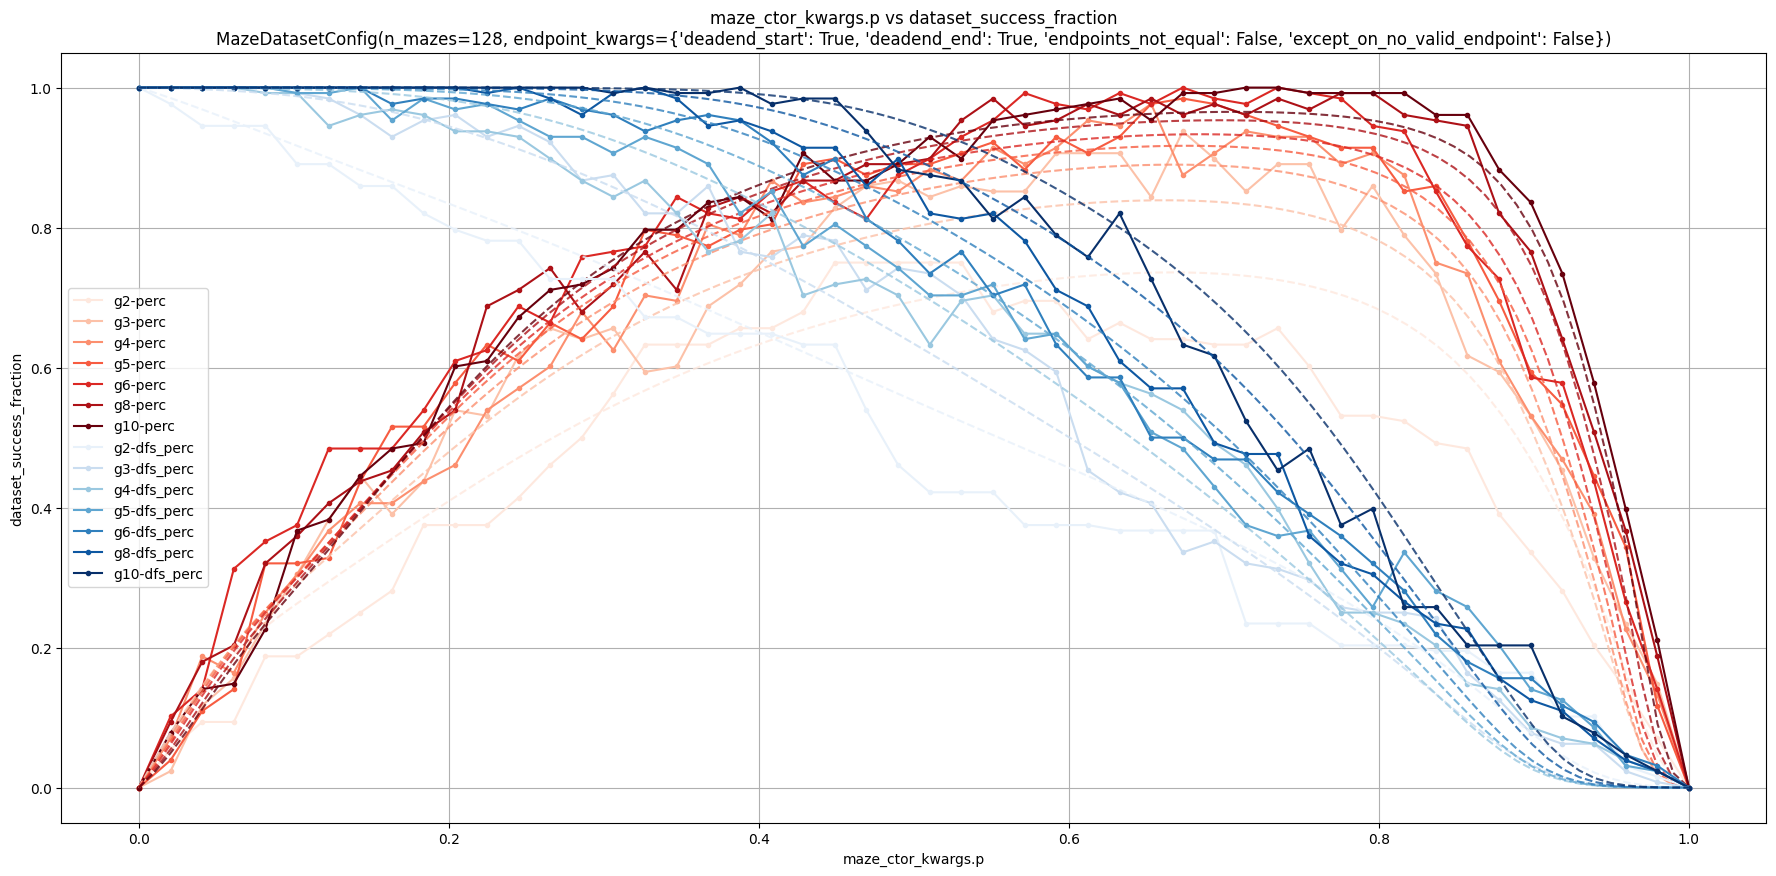

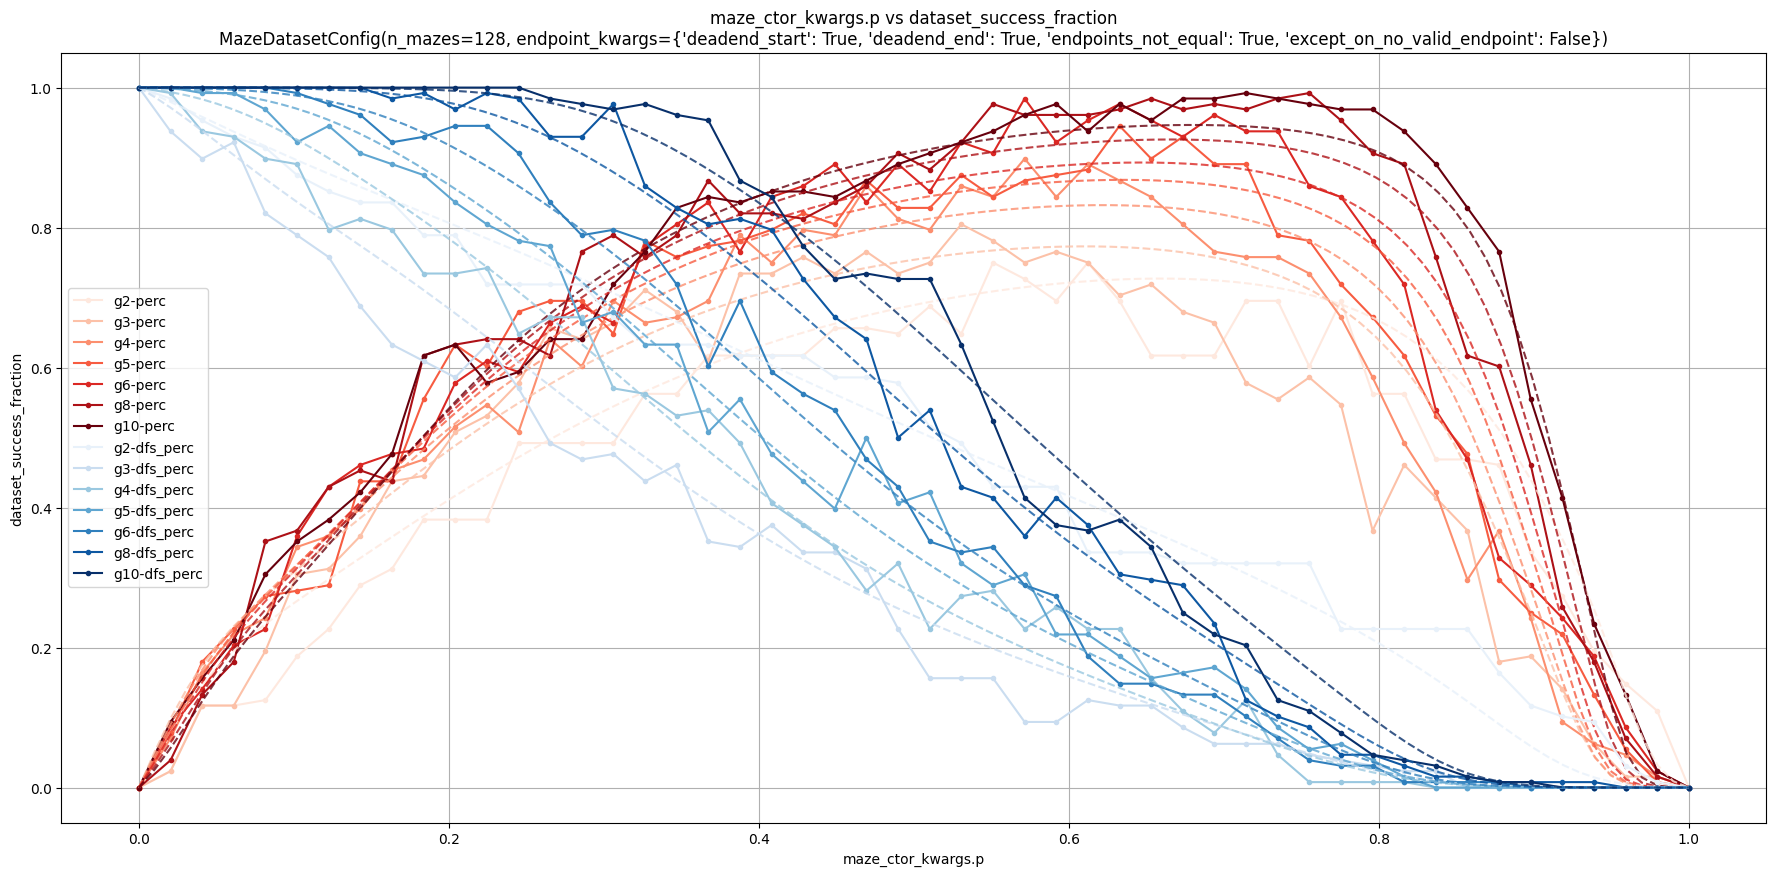

In [6]:
plot_grouped(
	results_medium,
	predict_fn=lambda x: x.success_fraction_estimate(),
	prediction_density=100,
	# for paper version
	# figsize=(14, 6),
	# save_fmt="pdf",
	# save_dir=Path("../docs/paper/figures/ep"),
	# minify_title=True,
	# legend_kwargs=dict(loc="center right", ncol=1, bbox_to_anchor=(1.05, 0.6)),
)

# perform a pysr regression on a dataset we load

/home/miv/projects/mazes/maze-dataset/.venv/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
Compiling Julia backend...


loaded data: data.summary() = {'len(configs)': 30, 'len(param_values)': 25, 'len(result_values)': 30, 'param_key': 'maze_ctor_kwargs.p', 'analyze_func': 'dataset_success_fraction'}
training data extracted: x.shape = (750, 5), y.shape = (750,)


/home/miv/projects/mazes/maze-dataset/.venv/lib/python3.12/site-packages/pysr/sr.py:87: UserWarning: You are using the `^` operator, but have not set up `constraints` for it. This may lead to overly complex expressions. One typical constraint is to use `constraints={..., '^': (-1, 1)}`, which will allow arbitrary-complexity base (-1) but only powers such as a constant or variable (1). For more tips, please see https://ai.damtp.cam.ac.uk/pysr/tuning/
  warnings.warn(
[ Info: Started!
[ Info: Final population:
[ Info: Results saved to:


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           1.151e-01  1.594e+01  y = 0.65077
3           9.782e-02  8.151e-02  y = 0.54285 ^ x₂
4           9.406e-02  3.916e-02  y = 1.2878 - sigmoid(x₂)
5           9.190e-02  2.320e-02  y = sigmoid(square(x₂ - 1.3885))
6           9.086e-02  1.137e-02  y = 0.56856 ^ (x₂ ^ square(x₄))
7           8.996e-02  9.995e-03  y = 0.62299 ^ (x₂ + (x₀ ^ x₁))
8           8.157e-02  9.796e-02  y = 0.62299 ^ square(x₂ + (x₀ ^ x₁))
9           7.621e-02  6.787e-02  y = (((x₂ - x₀) ^ x₂) ^ 0.46787) * 0.85572
11          7.360e-02  1.746e-02  y = sigmoid((1.9875 - x₂) - cube((x₂ + x₀) - 0.67704))
13          5.740e-02  1.243e-01  y = sigmoid(x₄ + cube(((x₀ * (x₄ + x₀)) * -1.0527) ^ x₂))
16          5.518e-02  1.315e-02  y = sigmoid(x₄ + cube(x₄ + cube((((x₀ * x₄) + x₀) * -1.052...
                                      7) ^ x₂)))
18          5.462e-02  5.034e

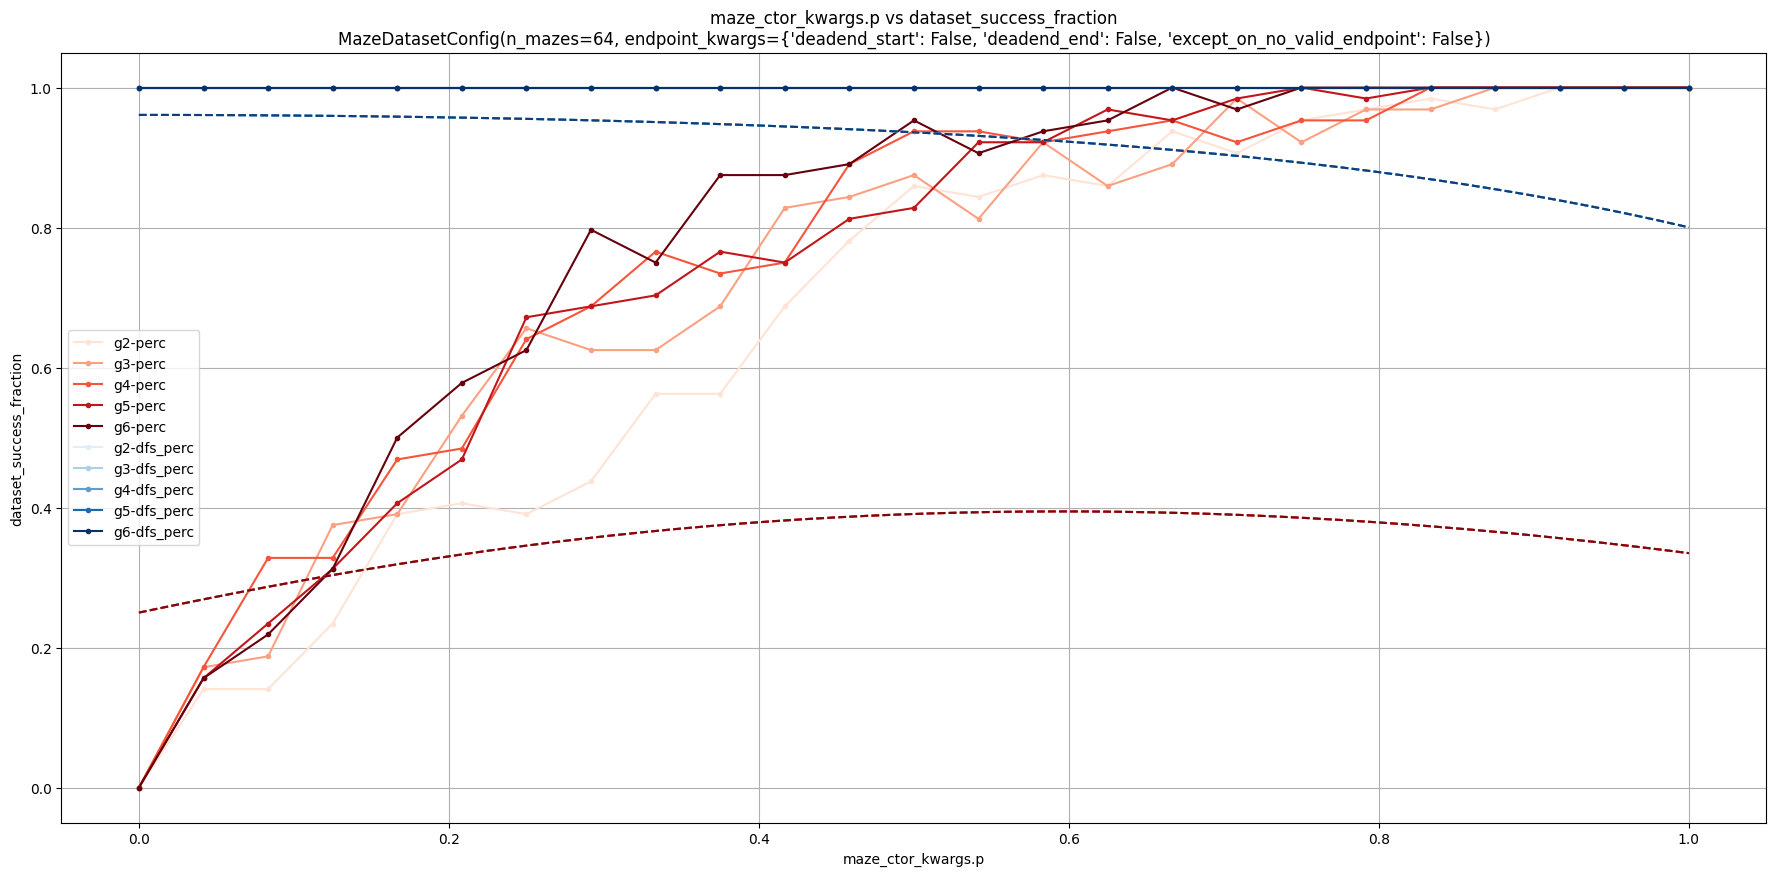

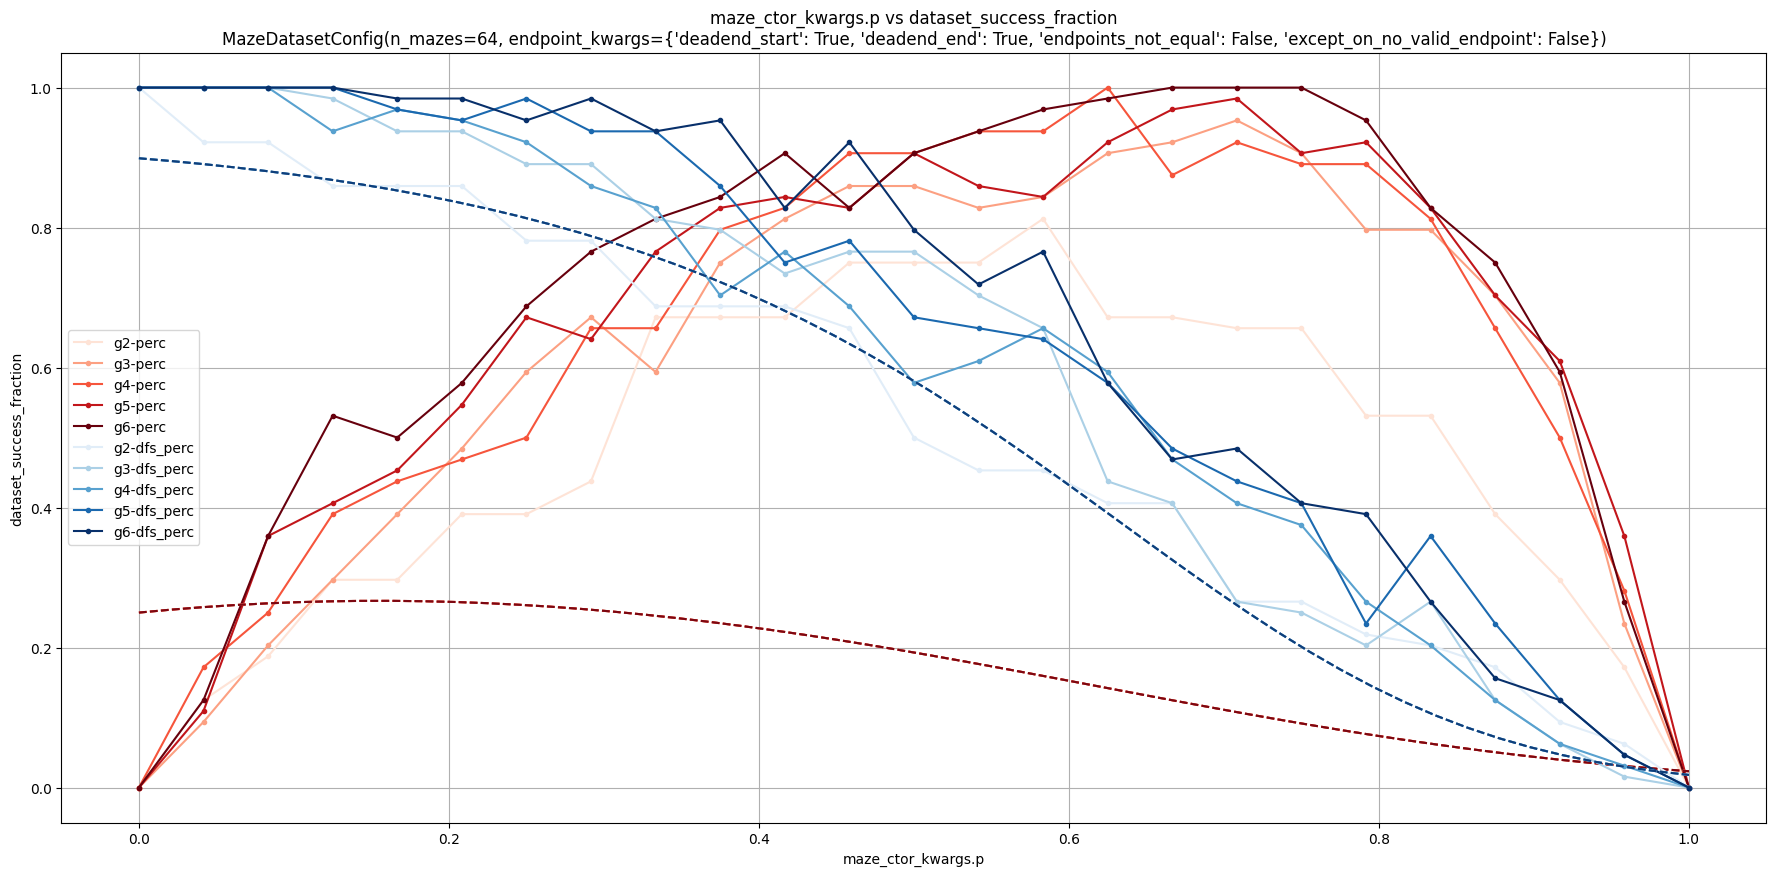

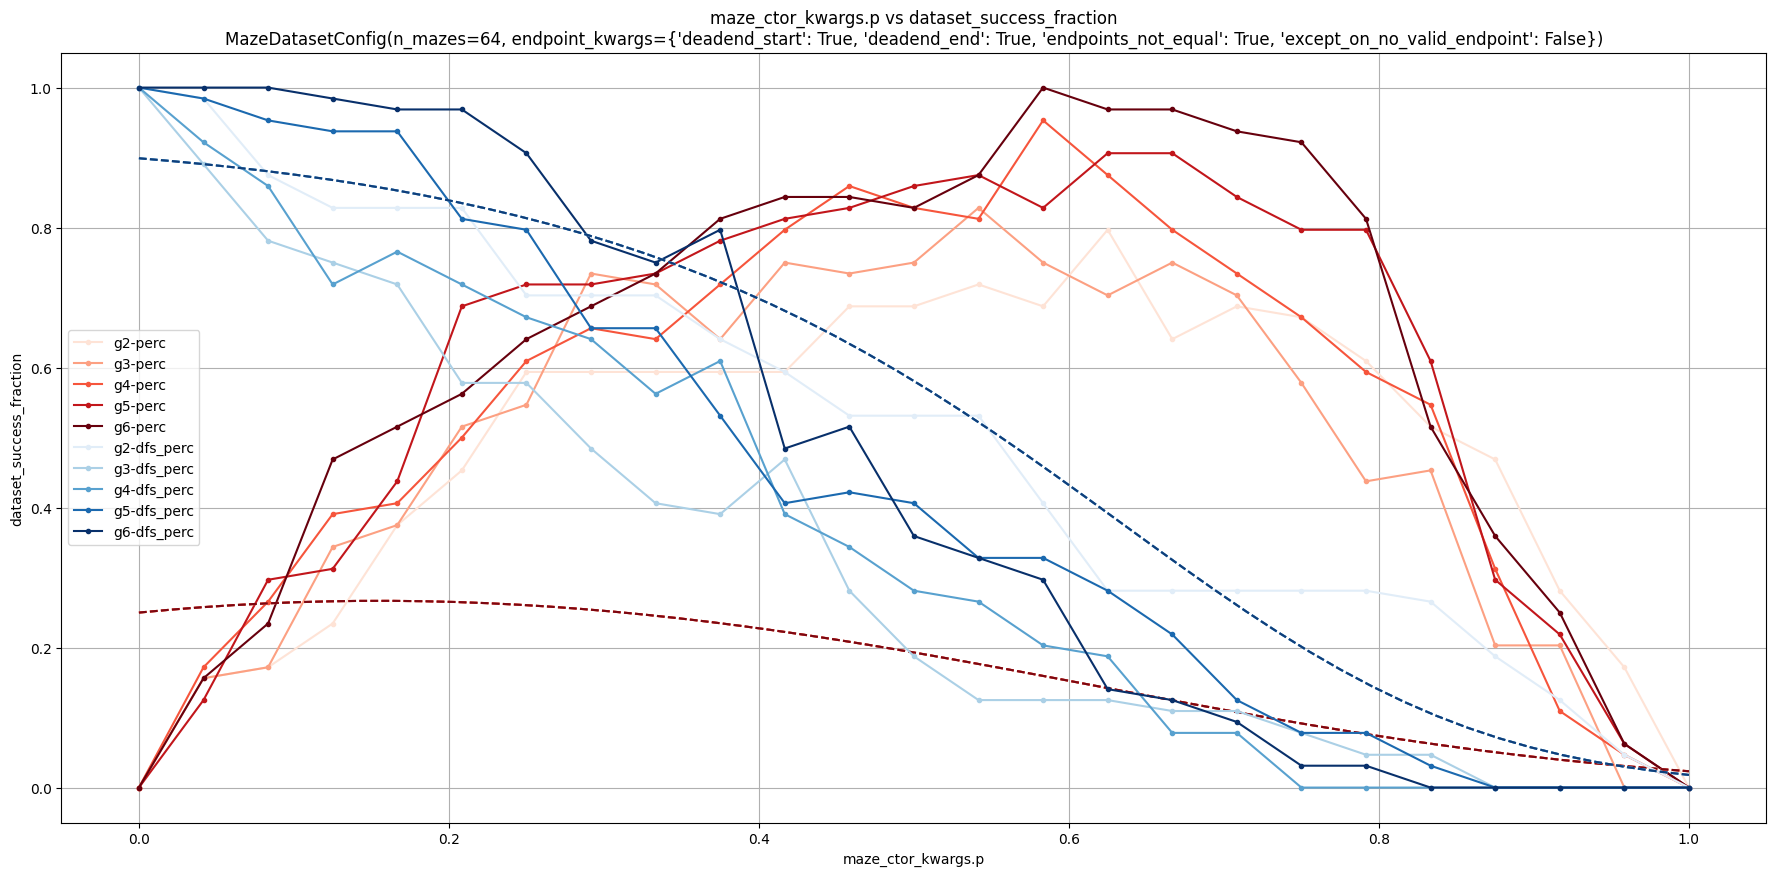

In [7]:
DATA_PATH_DIR: Path = Path("../docs/benchmarks/percolation_fractions/")
# DATA_PATH: str = DATA_PATH_DIR / "large/result-n256-c54-p100.zanj"
# DATA_PATH: str = DATA_PATH_DIR / "medium/result-n128-c42-p50.zanj"
DATA_PATH: str = DATA_PATH_DIR / "small/result-n64-c30-p25.zanj"
# DATA_PATH: str = DATA_PATH_DIR / "test/result-n16-c12-p16.zanj"

sweep_fit(
	DATA_PATH,
	Path("tests/_temp/fit_plots/"),
	niterations=3,
)

# interactive plots for figuring out `maze_dataset.math.soft_step()`

In [8]:
# Run the interactive visualization if in a Jupyter notebook
if "__vsc_ipynb_file__" in globals():
	from maze_dataset.benchmark.sweep_fit import create_interactive_plot

	create_interactive_plot(True)

In [9]:
cfg = MazeDatasetConfig(
	name="test",
	seed=3,
	grid_n=5,
	n_mazes=10,
	maze_ctor=LatticeMazeGenerators.gen_dfs_percolation,
	maze_ctor_kwargs=dict(p=0.7),
	endpoint_kwargs=dict(
		deadend_start=True,
		# deadend_end=True,
		endpoints_not_equal=True,
		except_on_no_valid_endpoint=False,
	),
)

print(f"{cfg.success_fraction_estimate() = }")
cfg_new = cfg.success_fraction_compensate()
print(f"{cfg_new.n_mazes = }")

/home/miv/projects/mazes/maze-dataset/maze_dataset/dataset/dataset.py:94: UserWarning: in GPTDatasetConfig self.name='test', self.seed=3 is trying to override GLOBAL_SEED = 42
  warnings.warn(


cfg.success_fraction_estimate() = np.float64(0.45037493871086454)
cfg_new.n_mazes = 27


In [10]:
len(MazeDataset.from_config(cfg_new))

12